# Random forest regression

## Data loading

In [1]:
import pandas as pd

def get_station_updates(city, station):
    df = pd.read_csv('challenge_data/{}/stations/{}.csv'.format(city, station))
    df.drop_duplicates(subset='moment', inplace=True)
    df['moment'] = pd.to_datetime(df['moment'])
    return df


def get_weather_updates(city):
    df = pd.read_csv('challenge_data/{}/weather.csv'.format(city))
    df.drop_duplicates(subset='moment', inplace=True)
    df['moment'] = pd.to_datetime(df['moment'])
    return df

## Pre-processing

In [2]:
def add_temporal_features(df):
    df['weekday'] = df['moment'].map(lambda m: str(m.weekday()))
    df['hour'] = df['moment'].map(lambda m: str(m.hour))
    df['minute'] = df['moment'].map(lambda m: m.minute)
    return df

    
def add_weather_updates(df, weather_df):
    w_times = pd.Series(weather_df['moment'].values, weather_df['moment'])
    w_times.sort_values(inplace=True)
    df['moment_weather'] = w_times.reindex(df['moment'], method='nearest').values
    joined_df = pd.merge(
        left=df,
        right=weather_df,
        left_on='moment_weather',
        right_on='moment',
        suffixes=('', '_y')
    )
    joined_df.drop('moment_y', 1, inplace=True)
    return joined_df


def preprocess(df, city):
    df = add_temporal_features(df)
    df = add_weather_updates(df, get_weather_updates(city))
    df.set_index('moment', drop=False, inplace=True)
    return df

## Temporal train-test split

In [3]:
def split_train_test(X, y, t0, t1, t2):
    X_train = X[(X.index >= t0) & (X.index < t1)].copy()
    X_test = X[(X.index >= t1) & (X.index <= t2)].copy()
    y_train = y[(X.index >= t0) & (X.index < t1)].copy()
    y_test = y[(X.index >= t1) & (X.index <= t2)].copy()
    return X_train, X_test, y_train, y_test

## Create a train set and a test for a single station

In [4]:
features = [
    'weekday',
    'hour',
    'minute',
    'clouds',
    'humidity',
    'pressure',
    'temperature',
    'wind'
]

city = 'toulouse'
station = '00003-pomme'

df = preprocess(get_station_updates(city, station), city)
X = df[features]
y = df['bikes']

t2 = X.index.max()
t1 = t2 - pd.Timedelta('5 days')
t0 = t1 - pd.Timedelta('12 days')

X_train, X_test, y_train, y_test = split_train_test(X, y, t0, t1, t2)

## Fit and predict a single station

In [5]:
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing

model = ensemble.RandomForestRegressor(
    n_estimators=5,
    max_depth=3,
    min_samples_leaf=2
).fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_test), index=y_test.index)

metrics.mean_absolute_error(y_test, y_pred)

3.4950667912393878

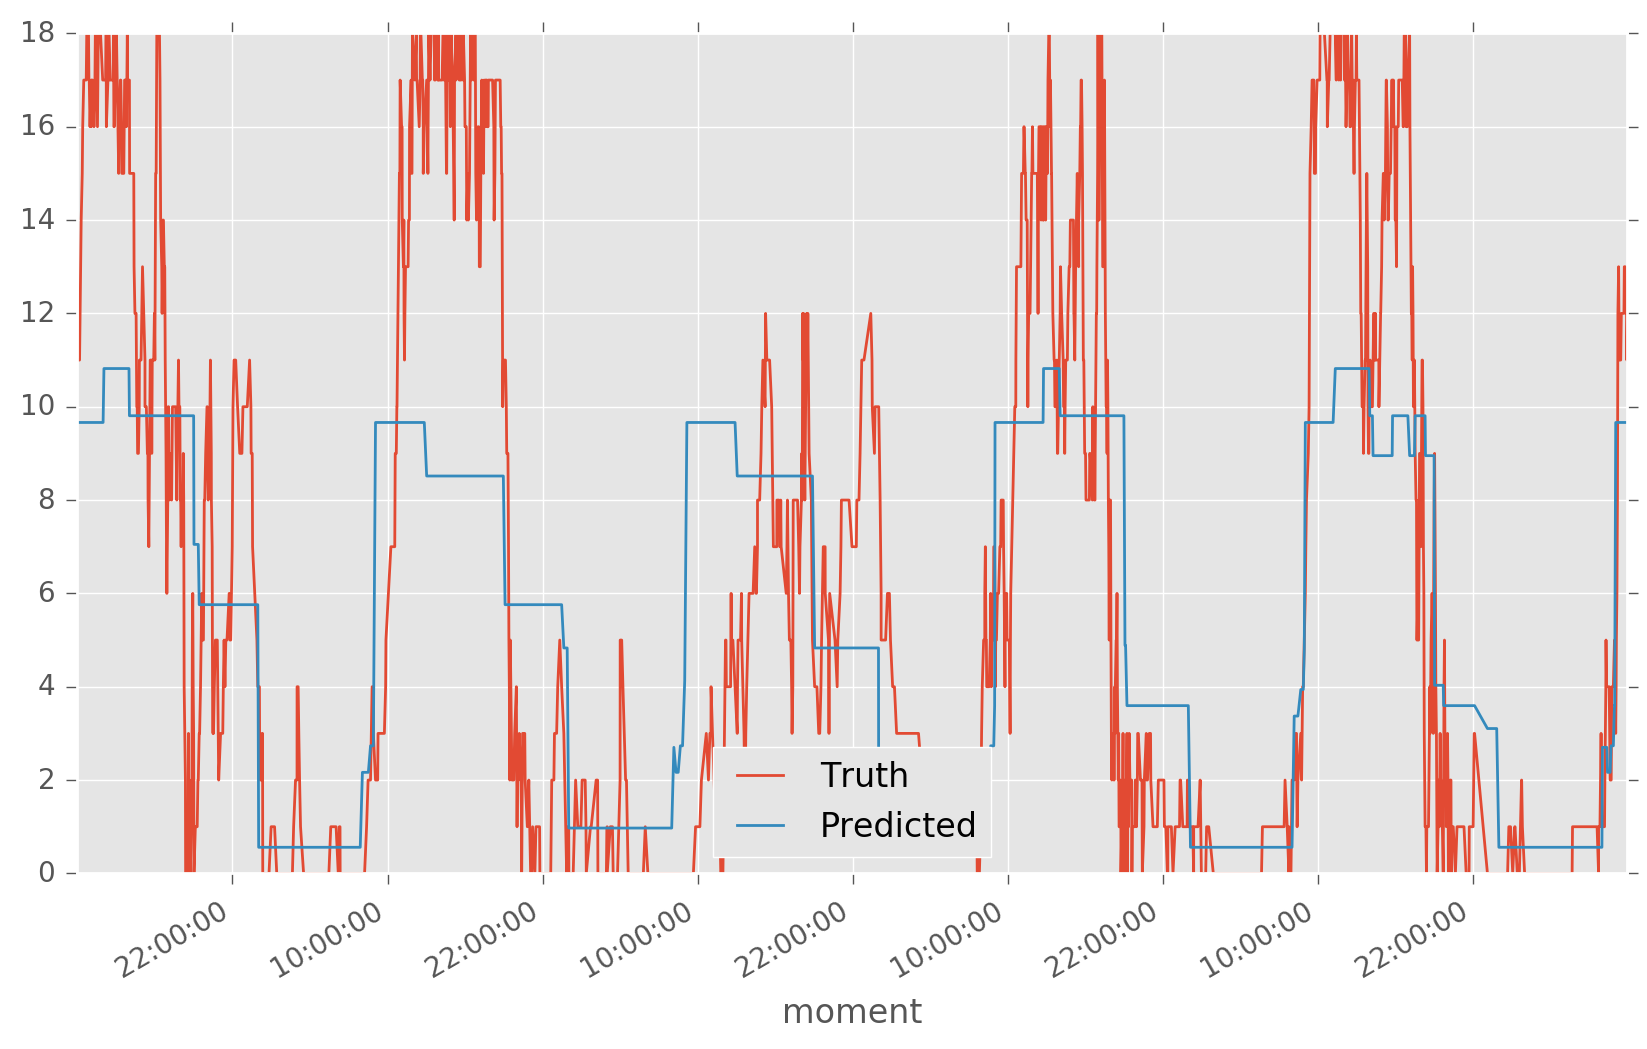

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(10, 6))
y_test.plot(label='Truth')
y_pred.plot(label='Predicted')
plt.legend(loc='lower center')

## Build a random forest through cross-validation for each station

In [7]:
from sklearn import metrics
from sklearn import model_selection

# Define the grid on which to look for optimal parameters

model = ensemble.RandomForestRegressor()

param_grid = {
    'n_estimators': (5, 8, 12, 50),
    'max_depth': (1, 3, 4, None),
    'min_samples_leaf': (1, 2, 3, 4)
}

grid_search = model_selection.GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=metrics.make_scorer(metrics.mean_absolute_error)
)

# Create regrssors for each station

to_predict_df = pd.read_csv('challenge_data/test-blank.csv', index_col=0)

regressors = {}

for station, group in to_predict_df.groupby('station'):
    city = group['city'][0]
    df = preprocess(get_station_updates(city, station), city)
    X = df[features]
    y = df['bikes']
    grid_search.fit(X, y)
    regressors[station] = grid_search.best_estimator_

## Forecast the number of bikes in test set

### Put the data to predict in shape so forecasts can be run

In [8]:
to_predict_df['moment'] = pd.to_datetime(to_predict_df.index)
to_predict_df = add_temporal_features(to_predict_df)

to_predict_weather_df = pd.read_csv('challenge_data/test-weather.csv')
to_predict_weather_df['moment'] = pd.to_datetime(to_predict_weather_df['moment'])

# Add the provided weather updates
df = pd.concat([
    pd.concat([
        add_weather_updates(
            g2.copy(),
            to_predict_weather_df[to_predict_weather_df['city'] == city]
        )
        for s, g2 in g1.groupby('station', sort=False)
    ])
    for c, g1 in to_predict_df.groupby('city', sort=False)   
]).reset_index(drop=True)

In [9]:
df['bikes'] = [
    regressors[row['station']].predict(row[features].values.reshape(1, -1))[0]
    for _, row in df.iterrows()
]

# Round to the closest value
df['bikes'] = df['bikes'].round()

## Save the dataframe for submission

In [10]:
df[['moment', 'city', 'station' ,'bikes']].set_index('moment').to_csv('submission.csv')